In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from textblob import TextBlob
import spacy
from imblearn.over_sampling import SMOTE
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nlp = spacy.load('en_core_web_sm')

# --- 🧹 Helper Functions ---
def clean_text(text):
    """More sophisticated text cleaning"""
    if not isinstance(text, str):
        return ""

    # Basic cleaning
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

    # Advanced cleaning with spaCy
    doc = nlp(text)
    cleaned_tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            cleaned_tokens.append(token.lemma_)

    return ' '.join(cleaned_tokens)

def calculate_readability(text):
    """Calculate Flesch Reading Ease score"""
    sentence_count = len(re.split(r'[.!?]', text))
    word_count = len(text.split())
    syllable_count = sum([len(re.findall(r'[aeiouy]+', word.lower())) for word in text.split()])

    if word_count == 0 or sentence_count == 0:
        return 0

    return 206.835 - 1.015 * (word_count/sentence_count) - 84.6 * (syllable_count/word_count)

In [ ]:
def read_data():
    """Load data with proper error handling"""
    try:
        df = pd.read_csv("/content/drive/MyDrive/customer_reviews/amazon_reviews_us_Major_Appliances_v1_00.tsv", on_bad_lines="skip",sep="\t", header=0, dtype={
            "marketplace": str,
            "customer_id": str,
            "review_id": str,
            "product_id": str,
            "product_parent": str,
            "product_title": str,
            "product_category": str,
            "star_rating": int,
            "helpful_votes": int,
            "total_votes": int,
            "vine": str,
            "verified_purchase": str,
            "review_headline": str,
            "review_body": str,
            "review_date": str
        })
        print(f"Data loaded successfully with {len(df)} records")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = read_data()

Data loaded successfully with 96834 records


In [ ]:
def preprocess_data(df):
    """Comprehensive data preprocessing"""
    if df is None:
        return None

    # Filter: total_votes >= 5 (more inclusive than original)
    df = df[df['total_votes'] >= 5].copy()

    # Create 'helpfulness' label: 1 if helpful votes ratio >= 0.5, else 0
    df['helpfulness'] = (df['helpful_votes'] / df['total_votes'] >= 0.5).astype(int)

    # Drop rows missing critical fields
    df.dropna(subset=['review_body', 'star_rating'], inplace=True)

    # Clean review text
    df['cleaned_review'] = df['review_body'].apply(clean_text)

    # Filter: review_length >= 10 words (more meaningful than 5)
    df = df[df['cleaned_review'].apply(lambda x: len(x.split()) >= 10)]

    # Remove duplicate reviews based on cleaned text and star rating
    df = df.drop_duplicates(subset=['cleaned_review', 'star_rating'])

    # Balance the dataset (handle class imbalance)
    print("\nClass distribution before balancing:")
    print(df['helpfulness'].value_counts(normalize=True))

    return df

df = preprocess_data(df)


Class distribution before balancing:
helpfulness
1    0.924463
0    0.075537
Name: proportion, dtype: float64


In [ ]:
def create_features(df):
    """Create comprehensive features for modeling"""
    if df is None:
        return None

    # Textual Features
    df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
    df['exclamations'] = df['review_body'].apply(lambda x: x.count('!'))
    df['questions'] = df['review_body'].apply(lambda x: x.count('?'))
    df['sentiment'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df['readability'] = df['review_body'].apply(calculate_readability)

    # Time-based features
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['days_since_first'] = (df['review_date'] - df['review_date'].min()).dt.days

    # Product features
    df['product_review_count'] = df.groupby('product_id')['review_id'].transform('count')

    # Reviewer features
    df['reviewer_review_count'] = df.groupby('customer_id')['review_id'].transform('count')

    return df

df = create_features(df)

In [ ]:
def split_data(df):
    """Split data into train and test sets"""
    if df is None:
        return None, None, None, None

    # Features to use
    numeric_features = ['star_rating', 'review_length', 'exclamations', 'questions',
                       'sentiment', 'subjectivity', 'readability', 'days_since_first',
                       'product_review_count', 'reviewer_review_count']

    X_text = df['cleaned_review']
    X_numeric = df[numeric_features]
    y = df['helpfulness']

    # Split with stratification to maintain class distribution
    X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
        X_text, X_numeric, y, test_size=0.2, random_state=42, stratify=y
    )

    return X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test

X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = split_data(df)


In [ ]:
def process_features(X_train_text, X_test_text, X_train_num, X_test_num):
    """Process text and numeric features"""
    # Text processing pipeline
    text_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('svd', TruncatedSVD(n_components=100))
    ])

    X_train_text_processed = text_pipe.fit_transform(X_train_text)
    X_test_text_processed = text_pipe.transform(X_test_text)

    # Numeric feature processing
    num_scaler = StandardScaler()
    X_train_num_processed = num_scaler.fit_transform(X_train_num)
    X_test_num_processed = num_scaler.transform(X_test_num)

    # Combine features
    X_train = np.hstack((X_train_num_processed, X_train_text_processed))
    X_test = np.hstack((X_test_num_processed, X_test_text_processed))

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    return X_train_resampled, X_test, y_train_resampled, y_test, text_pipe, num_scaler

X_train, X_test, y_train, y_test, text_pipe, num_scaler = process_features(
    X_train_text, X_test_text, X_train_num, X_test_num
)

In [ ]:
def train_model(X_train, y_train):
    """Train model with hyperparameter tuning"""
    # Use Random Forest which often works better for this type of problem
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    model = GridSearchCV(
        RandomForestClassifier(class_weight='balanced', random_state=42),
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    model.fit(X_train, y_train)

    print("\nBest model parameters:")
    print(model.best_params_)

    return model.best_estimator_

model = train_model(X_train, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best model parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}



Model Evaluation:
Accuracy: 0.8868

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.14      0.16       314
           1       0.93      0.95      0.94      3838

    accuracy                           0.89      4152
   macro avg       0.56      0.55      0.55      4152
weighted avg       0.87      0.89      0.88      4152



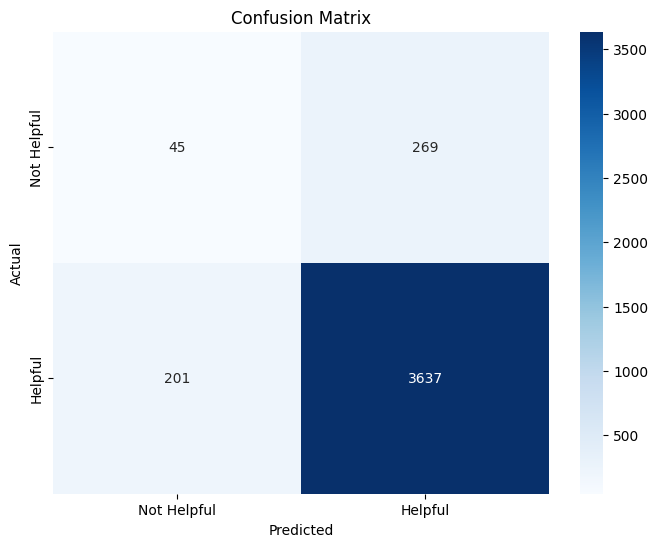

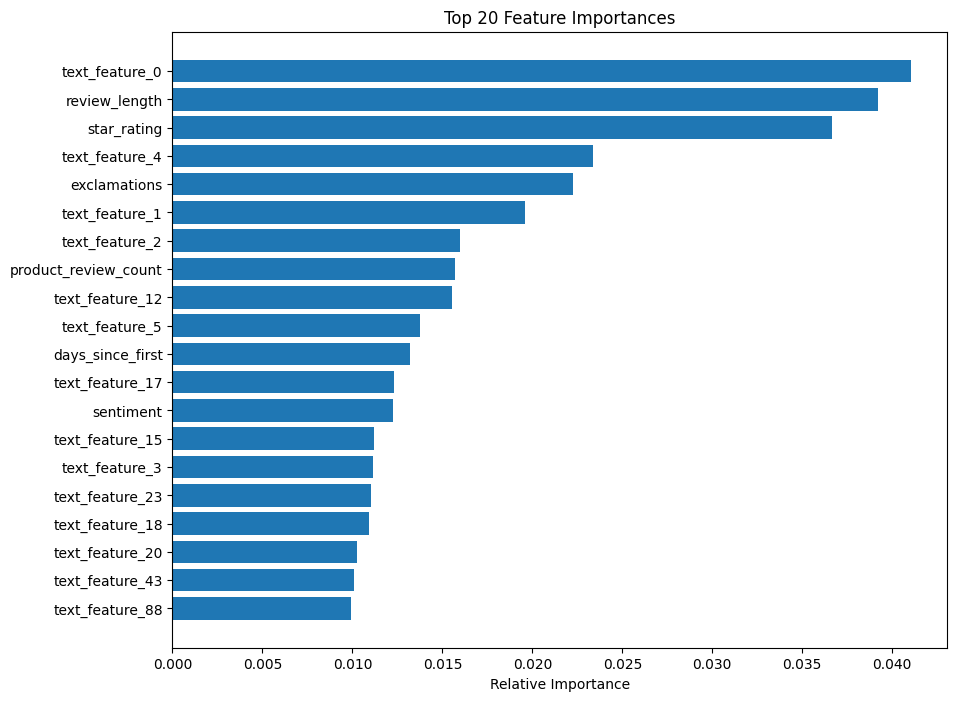

In [ ]:
def evaluate_model(model, X_test, y_test):
    """Comprehensive model evaluation"""
    y_pred = model.predict(X_test)

    print("\nModel Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Helpful', 'Helpful'],
                yticklabels=['Not Helpful', 'Helpful'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Feature importance
    if hasattr(model, 'feature_importances_'):
        feature_names = list(X_train_num.columns) + [f"text_feature_{i}" for i in range(100)]
        importances = model.feature_importances_
        indices = np.argsort(importances)[-20:]  # Top 20 features

        plt.figure(figsize=(10, 8))
        plt.title('Top 20 Feature Importances')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

evaluate_model(model, X_test, y_test)

In [ ]:
import joblib
import os

# Make sure folder exists
MODEL_DIR = '/content/drive/MyDrive/customer_reviews/'
os.makedirs(MODEL_DIR, exist_ok=True)

# Save models
joblib.dump(model, MODEL_DIR + 'helpfulness_model.pkl')
joblib.dump(text_pipe, MODEL_DIR + 'text_pipeline.pkl')
joblib.dump(num_scaler, MODEL_DIR + 'numeric_scaler.pkl')

print("✅ Models saved into Drive.")

✅ Models saved into Drive.


In [ ]:
from deep_translator import GoogleTranslator

def predict_helpfulness(rating, review_text):
    """Predict helpfulness of a new review with multilingual support"""
    try:
        # Load model and preprocessing objects
        model = joblib.load('/content/drive/MyDrive/customer_reviews/helpfulness_model.pkl')
        text_pipe = joblib.load('/content/drive/MyDrive/customer_reviews/text_pipeline.pkl')
        num_scaler = joblib.load('/content/drive/MyDrive/customer_reviews/numeric_scaler.pkl')

        # Translate review to English if not already
        try:
            translated_text = GoogleTranslator(source='auto', target='en').translate(review_text)
        except Exception as trans_error:
            print(f"Translation failed: {trans_error}")
            translated_text = review_text  # fallback to original if translation fails

        # Clean and process the translated review text
        cleaned = clean_text(translated_text)

        # Create text features
        text_vector = text_pipe.transform([cleaned])

        # Create numeric features
        length = len(cleaned.split())
        exclamations = translated_text.count('!')
        questions = translated_text.count('?')
        sentiment = TextBlob(cleaned).sentiment.polarity
        subjectivity = TextBlob(cleaned).sentiment.subjectivity
        readability = calculate_readability(translated_text)

        # For new reviews, we can't compute some features, so we'll use median values
        numeric_features = np.array([
            rating, length, exclamations, questions,
            sentiment, subjectivity, readability,
            0,  # days_since_first (unknown for new reviews)
            1,  # product_review_count (minimum)
            1   # reviewer_review_count (minimum)
        ]).reshape(1, -1)

        # Scale numeric features
        numeric_features_scaled = num_scaler.transform(numeric_features)

        # Combine features
        feature_vector = np.hstack((numeric_features_scaled, text_vector))

        # Make prediction
        prediction = model.predict(feature_vector)
        proba = model.predict_proba(feature_vector)[0]

        return {
            'prediction': 'Helpful' if prediction[0] == 1 else 'Not Helpful',
            'confidence': float(proba.max()),
            'details': {
                'rating': rating,
                'length': length,
                'sentiment': float(sentiment),
                'readability': float(readability),
                'helpful_prob': float(proba[1]),
                'not_helpful_prob': float(proba[0]),
                'original_review': review_text,
                'translated_review': translated_text
            }
        }
    except Exception as e:
        print(f"Prediction error: {e}")
        return {'error': str(e)}

In [ ]:
import joblib
examples = [
    (5, "I absolutely love this product! It exceeded all my expectations. The quality is outstanding and it arrived much faster than expected. Highly recommended to anyone considering this purchase."),
    (2, "El producto fue decepcionante. Se veía mucho mejor en las fotos que en la realidad. El material se siente barato y se rompió después de solo unos pocos usos. No lo recomendaría."),
    (1, "यह उत्पाद बेकार है। पैसे की बर्बादी। मत खरीदो।"),
    (4, "Bon produit dans l'ensemble, mais il y a quelques problèmes mineurs. La couleur est légèrement différente de celle montrée sur la photo."),
    (3, "It's okay. Not great, not terrible. Does what it's supposed to but nothing special. I expected better quality for the price.")


]

print("\nExample Predictions:")
for rating, review in examples:
    result = predict_helpfulness(rating, review)
    print(f"\nRating: {rating}")
    print(f"Review: {review[:100]}...")
    print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2f})")
    print(f"Details: {result['details']}")


Example Predictions:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Rating: 5
Review: I absolutely love this product! It exceeded all my expectations. The quality is outstanding and it a...
Prediction: Helpful (Confidence: 0.63)
Details: {'rating': 5, 'length': 14, 'sentiment': 0.33999999999999997, 'readability': 22.886714285714305, 'helpful_prob': 0.6306904761904761, 'not_helpful_prob': 0.36930952380952375, 'original_review': 'I absolutely love this product! It exceeded all my expectations. The quality is outstanding and it arrived much faster than expected. Highly recommended to anyone considering this purchase.', 'translated_review': 'I absolutely love this product! It exceeded all my expectations. The quality is outstanding and it arrived much faster than expected. Highly recommended to anyone considering this purchase.'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Rating: 2
Review: El producto fue decepcionante. Se veía mucho mejor en las fotos que en la realidad. El material se s...
Prediction: Not Helpful (Confidence: 0.57)
Details: {'rating': 2, 'length': 12, 'sentiment': -0.09999999999999998, 'readability': 71.025, 'helpful_prob': 0.42913095238095245, 'not_helpful_prob': 0.5708690476190477, 'original_review': 'El producto fue decepcionante. Se veía mucho mejor en las fotos que en la realidad. El material se siente barato y se rompió después de solo unos pocos usos. No lo recomendaría.', 'translated_review': 'The product was disappointing. It looked much better in the photos than in reality. The material feels cheap and broke after just a few uses. I would not recommend it.'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Rating: 1
Review: यह उत्पाद बेकार है। पैसे की बर्बादी। मत खरीदो।...
Prediction: Helpful (Confidence: 0.58)
Details: {'rating': 1, 'length': 5, 'sentiment': -0.35, 'readability': 76.55166666666669, 'helpful_prob': 0.5771488095238095, 'not_helpful_prob': 0.4228511904761904, 'original_review': 'यह उत्पाद बेकार है। पैसे की बर्बादी। मत खरीदो।', 'translated_review': 'This product is useless. Waste of money. Do not buy'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Rating: 4
Review: Bon produit dans l'ensemble, mais il y a quelques problèmes mineurs. La couleur est légèrement diffé...
Prediction: Helpful (Confidence: 0.55)
Details: {'rating': 4, 'length': 10, 'sentiment': 0.16249999999999998, 'readability': 60.47833333333335, 'helpful_prob': 0.5469940476190476, 'not_helpful_prob': 0.4530059523809524, 'original_review': "Bon produit dans l'ensemble, mais il y a quelques problèmes mineurs. La couleur est légèrement différente de celle montrée sur la photo.", 'translated_review': 'Good product overall, but there are some minor problems. The color is slightly different from that shown in the photo.'}

Rating: 3
Review: It's okay. Not great, not terrible. Does what it's supposed to but nothing special. I expected bette...
Prediction: Helpful (Confidence: 0.62)
Details: {'rating': 3, 'length': 9, 'sentiment': 0.1642857142857143, 'readability': 65.60057142857144, 'helpful_prob': 0.618095238095238, 'not_helpful_prob': 0.3819047619047619, 'original_revie

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
!pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install seaborn
import seaborn as sns

In [ ]:
examples = [
    (1, "यह उत्पाद बेकार है। पैसे की बर्बादी। मत खरीदो।"),
    (4, "Bon produit dans l'ensemble, mais il y a quelques problèmes mineurs. La couleur est légèrement différente de celle montrée sur la photo."),
    (2,"बहुत बढ़िया उत्पाद! पूरी तरह से संतुष्ट हूं।")



]

print("\nExample Predictions:")
for rating, review in examples:
    result = predict_helpfulness(rating, review)
    print(f"\nRating: {rating}")
    print(f"Review: {review[:100]}...")
    print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2f})")
    print(f"Details: {result['details']}")


Example Predictions:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Rating: 1
Review: यह उत्पाद बेकार है। पैसे की बर्बादी। मत खरीदो।...
Prediction: Helpful (Confidence: 0.58)
Details: {'rating': 1, 'length': 5, 'sentiment': -0.35, 'readability': 76.55166666666669, 'helpful_prob': 0.5771488095238095, 'not_helpful_prob': 0.4228511904761904, 'original_review': 'यह उत्पाद बेकार है। पैसे की बर्बादी। मत खरीदो।', 'translated_review': 'This product is useless. Waste of money. Do not buy'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Rating: 4
Review: Bon produit dans l'ensemble, mais il y a quelques problèmes mineurs. La couleur est légèrement diffé...
Prediction: Helpful (Confidence: 0.55)
Details: {'rating': 4, 'length': 10, 'sentiment': 0.16249999999999998, 'readability': 60.47833333333335, 'helpful_prob': 0.5469940476190476, 'not_helpful_prob': 0.4530059523809524, 'original_review': "Bon produit dans l'ensemble, mais il y a quelques problèmes mineurs. La couleur est légèrement différente de celle montrée sur la photo.", 'translated_review': 'Good product overall, but there are some minor problems. The color is slightly different from that shown in the photo.'}

Rating: 2
Review: बहुत बढ़िया उत्पाद! पूरी तरह से संतुष्ट हूं।...
Prediction: Not Helpful (Confidence: 0.55)
Details: {'rating': 2, 'length': 4, 'sentiment': 0.75, 'readability': 7.405000000000001, 'helpful_prob': 0.44995238095238094, 'not_helpful_prob': 0.5500476190476191, 'original_review': 'बहुत बढ़िया उत्पाद! पूरी तरह से संतुष्ट हूं।', 'translated_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
